# Image Classification with Google MobileNetV2

## Import Libraries

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
import warnings
warnings.filterwarnings("ignore")
import kagglehub


In [2]:
# Kinds of flowers
kinds = np.array(os.listdir('C:/fruit_recognition/client/src/predict/archive/train'))
print(f"Kinds in this dataset: {kinds}")

Kinds in this dataset: ['apple' 'banana' 'beetroot' 'bell pepper' 'cabbage' 'capsicum' 'carrot'
 'cauliflower' 'chilli pepper' 'corn' 'cucumber' 'eggplant' 'garlic'
 'ginger' 'grapes' 'jalepeno' 'kiwi' 'lemon' 'lettuce' 'mango' 'onion'
 'orange' 'paprika' 'pear' 'peas' 'pineapple' 'pomegranate' 'potato'
 'raddish' 'soy beans' 'spinach' 'sweetcorn' 'sweetpotato' 'tomato'
 'turnip' 'watermelon']


In [3]:
# Paths of directories
path = 'C:/fruit_recognition/client/src/predict/archive/train'
kind_path = [path + "/" + year for year in kinds]
kind_path

['C:/fruit_recognition/client/src/predict/archive/train/apple',
 'C:/fruit_recognition/client/src/predict/archive/train/banana',
 'C:/fruit_recognition/client/src/predict/archive/train/beetroot',
 'C:/fruit_recognition/client/src/predict/archive/train/bell pepper',
 'C:/fruit_recognition/client/src/predict/archive/train/cabbage',
 'C:/fruit_recognition/client/src/predict/archive/train/capsicum',
 'C:/fruit_recognition/client/src/predict/archive/train/carrot',
 'C:/fruit_recognition/client/src/predict/archive/train/cauliflower',
 'C:/fruit_recognition/client/src/predict/archive/train/chilli pepper',
 'C:/fruit_recognition/client/src/predict/archive/train/corn',
 'C:/fruit_recognition/client/src/predict/archive/train/cucumber',
 'C:/fruit_recognition/client/src/predict/archive/train/eggplant',
 'C:/fruit_recognition/client/src/predict/archive/train/garlic',
 'C:/fruit_recognition/client/src/predict/archive/train/ginger',
 'C:/fruit_recognition/client/src/predict/archive/train/grapes',
 '

In [4]:
# Numbers of flowers for each kinds
for i, kind in enumerate(kind_path):
    print(f"There are {len(os.listdir(kind))} pictures in {kinds[i]}")

There are 68 pictures in apple
There are 75 pictures in banana
There are 88 pictures in beetroot
There are 90 pictures in bell pepper
There are 92 pictures in cabbage
There are 89 pictures in capsicum
There are 82 pictures in carrot
There are 79 pictures in cauliflower
There are 87 pictures in chilli pepper
There are 87 pictures in corn
There are 94 pictures in cucumber
There are 84 pictures in eggplant
There are 92 pictures in garlic
There are 68 pictures in ginger
There are 100 pictures in grapes
There are 88 pictures in jalepeno
There are 88 pictures in kiwi
There are 82 pictures in lemon
There are 97 pictures in lettuce
There are 86 pictures in mango
There are 94 pictures in onion
There are 69 pictures in orange
There are 83 pictures in paprika
There are 89 pictures in pear
There are 100 pictures in peas
There are 99 pictures in pineapple
There are 79 pictures in pomegranate
There are 77 pictures in potato
There are 81 pictures in raddish
There are 97 pictures in soy beans
There ar

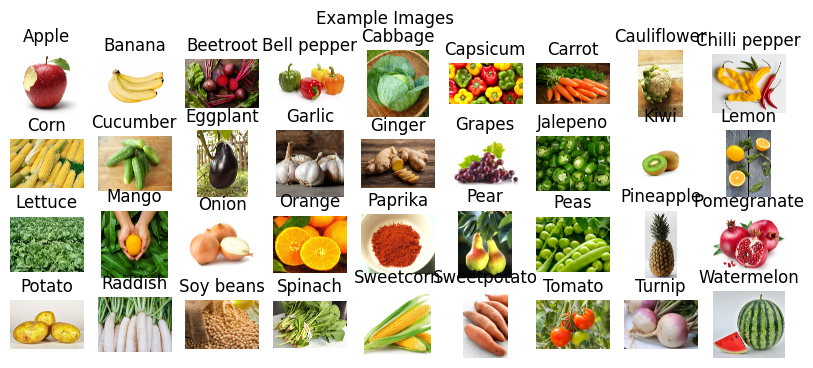

In [5]:
# Example images for each kinds
plt.figure(figsize=(10, 4))
plt.suptitle("Example Images")

num_kinds = len(kinds)
num_cols = min(num_kinds, 9)  # Ensure maximum of 9 columns
num_rows = (num_kinds + num_cols - 1) // num_cols

for i, kind in enumerate(kinds):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    # Get all JPG files in the directory
    jpg_files = [file for file in os.listdir(kind_path[i]) if file.lower().endswith('.jpg')]
    # Use the first file if available
    if jpg_files:
        path = os.path.join(kind_path[i], jpg_files[0])
        img = plt.imread(path)
        plt.imshow(img)
        plt.title(kind.capitalize())
        plt.axis("off")
    else:
        print(f"No JPG file found in directory: {kind_path[i]}")

plt.show()

In [6]:
# All ids


id_df = []
for i in range(len(kinds)):
    # 获取 kind_path[i] 目录下所有以 .jpg 结尾的文件
    jpg_files = [img.split(".")[0] for img in os.listdir(kind_path[i]) if img.lower().endswith('.jpg')]
    id_df.extend(jpg_files)

len(id_df)

2855

In [7]:
# All kinds
kind_df = []
for i, kind in enumerate(kinds):
    # 获取 kind_path[i] 目录下所有以 .jpg 结尾的文件
    jpg_files = os.listdir(kind_path[i])
    jpg_files = [img.split(".")[0] for img in jpg_files if img.lower().endswith('.jpg')]
    for x in range(len(jpg_files)):
        kind_df.append(kind)

len(kind_df)

2855

In [8]:
# Create a dataframe
df = pd.DataFrame(columns=["id", "kind"])
df["id"] = id_df
df["kind"] = kind_df
df.tail()

,id,kind
2850,Image_95,watermelon
2851,Image_96,watermelon
2852,Image_97,watermelon
2853,Image_98,watermelon
2854,Image_99,watermelon


In [9]:
# Check numbers
df["kind"].value_counts()

kind
peas             94
soy beans        93
grapes           91
spinach          90
turnip           90
lettuce          89
cabbage          89
sweetcorn        86
capsicum         85
beetroot         85
pineapple        85
corn             85
tomato           84
cucumber         84
garlic           84
chilli pepper    82
kiwi             82
onion            81
watermelon       80
eggplant         80
bell pepper      80
jalepeno         80
mango            79
pear             77
paprika          75
pomegranate      75
carrot           74
cauliflower      74
raddish          72
sweetpotato      69
potato           68
lemon            65
ginger           64
banana           63
orange           62
apple            59
Name: count, dtype: int64

In [10]:
filenames = []
for i in range(len(kinds)):
    # 获取 kind_path[i] 目录下所有以 .jpg 结尾的文件
    jpg_files = [kind_path[i] + "/" + kind for kind in os.listdir(kind_path[i]) if kind.lower().endswith('.jpg')]
    filenames.extend(jpg_files)

filenames[:5]


['C:/fruit_recognition/client/src/predict/archive/train/apple/Image_1.jpg',
 'C:/fruit_recognition/client/src/predict/archive/train/apple/Image_10.jpg',
 'C:/fruit_recognition/client/src/predict/archive/train/apple/Image_16.jpg',
 'C:/fruit_recognition/client/src/predict/archive/train/apple/Image_17.jpg',
 'C:/fruit_recognition/client/src/predict/archive/train/apple/Image_18.jpg']

In [11]:
# Check a random flower
print(filenames[2317])
print(df.loc[2317])

C:/fruit_recognition/client/src/predict/archive/train/soy beans/Image_62.jpg
id       Image_62
kind    soy beans
Name: 2317, dtype: object


In [12]:
boolean_kinds = [kind == kinds for kind in kind_df ]
boolean_kinds[:5]

[array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False]),
 array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False]),
 array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False]),
 array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,


In [13]:
len(boolean_kinds)

2855

## Creating test and train sets

In [14]:
X = filenames
y = boolean_kinds

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=18)
len(X_train), len(X_test), len(y_train), len(y_test)

(2284, 571, 2284, 571)

In [16]:
X_train[:3], y_train[:3]

(['C:/fruit_recognition/client/src/predict/archive/train/kiwi/Image_99.jpg',
  'C:/fruit_recognition/client/src/predict/archive/train/cucumber/Image_100.jpg',
  'C:/fruit_recognition/client/src/predict/archive/train/kiwi/Image_66.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False,  True, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False]),
  array([False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False]),
  array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False,  True, False,
         False, False, False, False, Fa

## Preprocessing Images

In [17]:
image = imread(filenames[15])
image.shape

(1000, 2000, 3)

In [18]:
image.max(), image.min()

(255, 0)

In [19]:
image[:50]

array([[[242, 242, 242],
        [242, 242, 242],
        [242, 242, 242],
        ...,
        [235, 235, 235],
        [235, 235, 235],
        [235, 235, 235]],

       [[242, 242, 242],
        [242, 242, 242],
        [242, 242, 242],
        ...,
        [235, 235, 235],
        [235, 235, 235],
        [234, 234, 234]],

       [[242, 242, 242],
        [242, 242, 242],
        [242, 242, 242],
        ...,
        [235, 235, 235],
        [234, 234, 234],
        [234, 234, 234]],

       ...,

       [[244, 244, 244],
        [244, 244, 244],
        [243, 243, 243],
        ...,
        [234, 234, 234],
        [234, 234, 234],
        [235, 235, 235]],

       [[243, 243, 245],
        [243, 243, 245],
        [243, 243, 245],
        ...,
        [236, 236, 236],
        [235, 235, 233],
        [234, 234, 232]],

       [[242, 242, 244],
        [242, 242, 244],
        [242, 242, 244],
        ...,
        [236, 236, 236],
        [235, 235, 233],
        [234, 234, 232]]

In [20]:
# turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 2000, 3), dtype=uint8, numpy=
array([[[242, 242, 242],
        [242, 242, 242],
        [242, 242, 242],
        ...,
        [235, 235, 235],
        [235, 235, 235],
        [235, 235, 235]],

       [[242, 242, 242],
        [242, 242, 242],
        [242, 242, 242],
        ...,
        [235, 235, 235],
        [235, 235, 235],
        [234, 234, 234]]], dtype=uint8)>

In [21]:
img_size = 224

In [22]:
# Create a function for preprocessing images
def process_image(image_path, img_size=img_size):
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[img_size, img_size])

  return image

In [23]:
process_image(X[17]), tf.constant(y[17])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         ...,
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785]],
 
        [[0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         ...,
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785]],
 
        [[0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         ...,
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785]],
 
        ...,
 
        [[0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785]

## Creating data batches

In [24]:
# Create a simple function to return a tuple (image, label)
def get_image_label (image_path, label):
  image = process_image(image_path)
  return image, label

In [25]:
batch_size = 32

In [26]:
# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=batch_size, test_data=False):
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                   tf.constant(y)))
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(X))

        # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
        data = data.map(get_image_label)

        # Turn the training data into batches
        data_batch = data.batch(batch_size)
        return data_batch

In [27]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
test_data = create_data_batches(X_test, y_test)

In [28]:
train_data.element_spec, test_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 36), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 36), dtype=tf.bool, name=None)))

In [29]:
train_images, train_labels = next(train_data.as_numpy_iterator())
#test_images, test_labels = next(test_data.as_numpy_iterator())
train_images[:2], train_labels[:2]

(array([[[[0.05616247, 0.        , 0.        ],
          [0.07369323, 0.02964436, 0.01360919],
          [0.08487395, 0.05718037, 0.01693052],
          ...,
          [0.36680192, 0.21263254, 0.03173839],
          [0.79992914, 0.64369667, 0.44610006],
          [0.4790852 , 0.3346174 , 0.12440082]],
 
         [[0.03421994, 0.        , 0.        ],
          [0.05462185, 0.02751851, 0.01666542],
          [0.02955182, 0.014377  , 0.        ],
          ...,
          [0.78070617, 0.63047457, 0.25347057],
          [0.7934923 , 0.6366294 , 0.27430633],
          [0.56548125, 0.41036922, 0.08756253]],
 
         [[0.01831483, 0.00341512, 0.00733669],
          [0.02009804, 0.01379552, 0.01694678],
          [0.01506728, 0.0166079 , 0.00953507],
          ...,
          [0.46069822, 0.31691915, 0.09009211],
          [0.5844363 , 0.43657959, 0.2198985 ],
          [0.2915246 , 0.14481592, 0.        ]],
 
         ...,
 
         [[0.4845399 , 0.27046445, 0.        ],
          [0.49035

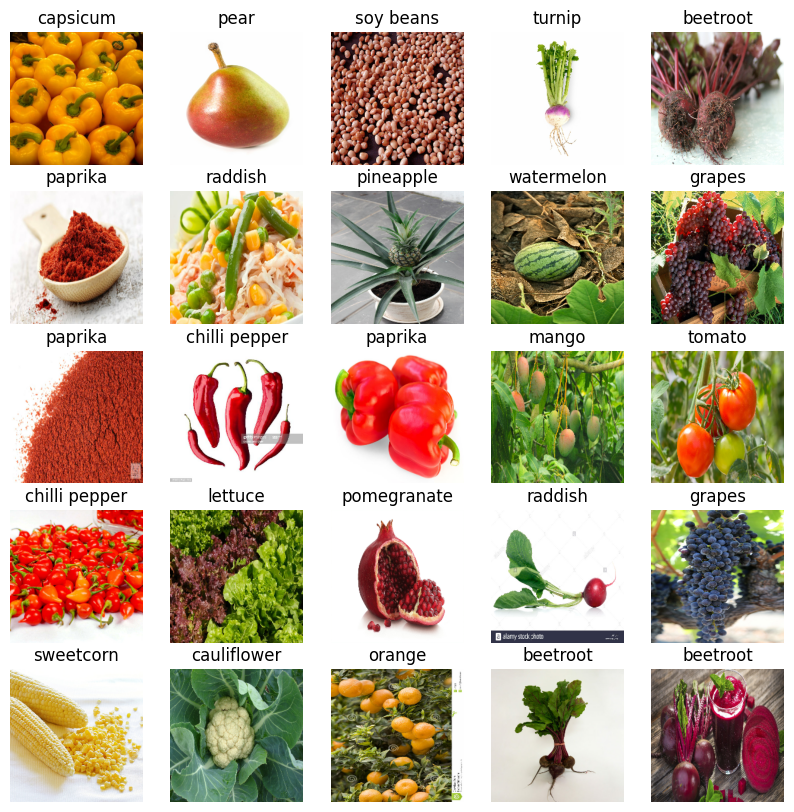

In [30]:
# Visualizing data batches
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(train_images[i])
    plt.title(kinds[train_labels[i].argmax()])
    plt.axis("off")

## Model

In [31]:
# Setup input shape to the model
input_shape = [None, img_size, img_size, 3] # batch, height, width, colour channels
# Setup output shape of our model
output_shape = len(kinds)

In [32]:
import kagglehub

# Download latest version
path = kagglehub.model_download("google/mobilenet-v2/tensorFlow2/140-224-classification")

print("Path to model files:", path)

Path to model files: C:\Users\thang\.cache\kagglehub\models\google\mobilenet-v2\tensorFlow2\140-224-classification\2


In [33]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Lambda(lambda x: hub.KerasLayer("C:/Users/thang/.cache/kagglehub/models/google/mobilenet-v2/tensorFlow2/140-224-classification/2")(x)),  # MobileNet V2作为特征提取器
#     tf.keras.layers.BatchNormalization(),  # 批归一化层
#     tf.keras.layers.Dense(units=output_shape, activation="softmax")  # 输出层
    
# ])

model = tf.keras.Sequential([
    hub.KerasLayer("C:/Users/thang/.cache/kagglehub/models/google/mobilenet-v2/tensorFlow2/140-224-classification/2"),  # MobileNet V2作为特征提取器
    tf.keras.layers.BatchNormalization(),  # 批归一化层
    tf.keras.layers.Dense(units=output_shape, activation="softmax")  # 输出层
])

In [34]:
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

In [35]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))  # Resize to match the model input shape
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    image /= 255.0  # Normalize to [0, 1] range
    return image

In [36]:
model.build(input_shape)

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              6158505   
                                                                 
 batch_normalization (Batch  (None, 1001)              4004      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 36)                36072     
                                                                 
Total params: 6198581 (23.65 MB)
Trainable params: 38074 (148.73 KB)
Non-trainable params: 6160507 (23.50 MB)
_________________________________________________________________


In [38]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                  patience=3)

In [39]:
import tensorflow as tf
print("Num GPUs Avail able: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Avail able:  0


In [40]:
history = model.fit(x=train_data,
                    epochs=10,
                    callbacks=[early_stopping],
                    
                   validation_data=test_data)


Epoch 1/10



72/72 [==============================] - 89s 1s/step - loss: 1.8640 - accuracy: 0.5048 - val_loss: 0.8889 - val_accuracy: 0.7496
Epoch 2/10
72/72 [==============================] - 86s 1s/step - loss: 0.6142 - accuracy: 0.8170 - val_loss: 0.7091 - val_accuracy: 0.7863
Epoch 3/10
72/72 [==============================] - 88s 1s/step - loss: 0.3874 - accuracy: 0.8796 - val_loss: 0.6590 - val_accuracy: 0.8021
Epoch 4/10
72/72 [==============================] - 87s 1s/step - loss: 0.2805 - accuracy: 0.9225 - val_loss: 0.6354 - val_accuracy: 0.8091
Epoch 5/10
72/72 [==============================] - 86s 1s/step - loss: 0.2094 - accuracy: 0.9457 - val_loss: 0.6234 - val_accuracy: 0.8126
Epoch 6/10
72/72 [==============================] - 87s 1s/step - loss: 0.1659 - accuracy: 0.9567 - val_loss: 0.6366 - val_accuracy: 0.8056
Epoch 7/10
72/72 [==============================] - 84s 1s/step - loss: 0.1362 - accuracy: 0.9715 - val_loss: 0.6328 - val_accuracy: 0.8109
Epoch 8/10
72/72 [=============

In [41]:
final_model_path ="C:/fruit_recognition/client/src/predict/model.h5"
model.save(final_model_path)


In [42]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='mobilenet.png', show_shapes=True)

AttributeError: module 'pydot' has no attribute 'InvocationException'

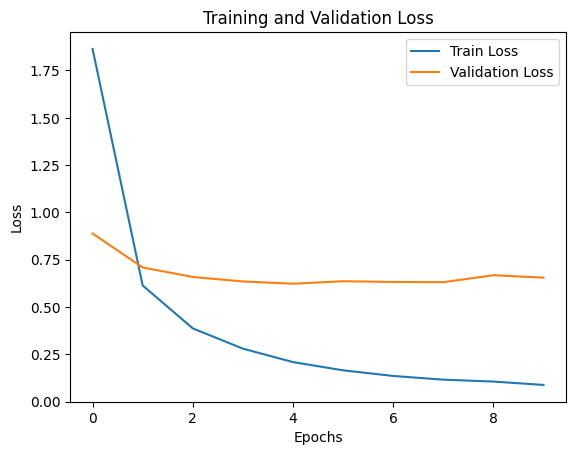

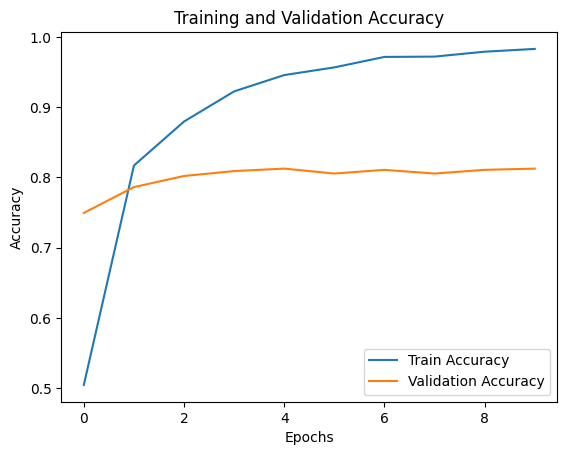

18/18 [==============================] - 20s 1s/step - loss: 0.6557 - accuracy: 0.8126
Validation Loss: 0.6557
Validation Accuracy: 0.8126


In [43]:
# 绘制训练集和验证集的损失曲线
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制训练集和验证集的准确率曲线
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 计算验证集的损失和准确率
loss, accuracy = model.evaluate(test_data)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

## Predictions

In [44]:
def create_data_batches(X, y=None, batch_size=batch_size, test_data=False):
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
        data_batch = data.map(process_image).batch(batch_size)
        return data_batch
    else:
        print("Creating data batches...")
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                   tf.constant(y)))
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(X))

        # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
        data = data.map(get_image_label)

        # Turn the training data into batches
        data_batch = data.batch(batch_size)
        return data_batch

In [45]:
train_data = create_data_batches(X_train, y_train)
test_data = create_data_batches(X_test, test_data=True)

Creating data batches...
Creating test data batches...


In [46]:
predictions = model.predict(test_data)
predictions

18/18 [==============================] - 18s 852ms/step


array([[9.8638402e-06, 7.9106467e-06, 5.5892659e-08, ..., 1.3952607e-06,
        6.6511670e-06, 7.1270620e-07],
       [4.3271311e-06, 5.4465668e-06, 7.4972733e-05, ..., 1.9149766e-07,
        2.7995861e-06, 4.5219515e-04],
       [1.8014593e-05, 1.3510173e-06, 6.4740311e-06, ..., 4.6380985e-05,
        1.8345013e-06, 1.3725008e-06],
       ...,
       [2.7481709e-08, 1.1965157e-06, 8.3656879e-08, ..., 8.4714543e-08,
        2.2637950e-07, 3.2618598e-06],
       [1.2783601e-03, 2.1037937e-05, 1.8888667e-03, ..., 2.9975742e-02,
        1.1237318e-04, 6.9309230e-04],
       [6.9814718e-08, 1.3477053e-03, 1.8904326e-02, ..., 3.5679182e-05,
        3.0498751e-04, 2.9986290e-07]], dtype=float32)

In [47]:
true_labels = [kinds[np.argmax(data)] for data in y_test]
pred_labels = [kinds[np.argmax(pred)] for pred in predictions]

In [48]:
true_labels[:20]

['mango',
 'garlic',
 'capsicum',
 'ginger',
 'cabbage',
 'jalepeno',
 'lemon',
 'soy beans',
 'corn',
 'garlic',
 'kiwi',
 'pineapple',
 'orange',
 'paprika',
 'sweetpotato',
 'chilli pepper',
 'tomato',
 'paprika',
 'jalepeno',
 'cauliflower']

In [49]:
pred_labels[:20]

['mango',
 'garlic',
 'chilli pepper',
 'ginger',
 'cabbage',
 'jalepeno',
 'orange',
 'soy beans',
 'corn',
 'garlic',
 'kiwi',
 'pineapple',
 'onion',
 'chilli pepper',
 'sweetpotato',
 'chilli pepper',
 'tomato',
 'tomato',
 'chilli pepper',
 'cauliflower']

In [50]:
print(accuracy_score(true_labels, pred_labels))

0.8126094570928196


In [4]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import warnings

warnings.filterwarnings("ignore")

# Function to preprocess the image
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize to match the model input shape
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    image /= 255.0  # Normalize to [0, 1] range
    return image

# Load the trained model
model_path = "C:/fruit_recognition/client/src/predict/model.h5"
model = tf.keras.models.load_model(model_path, custom_objects={'KerasLayer': hub.KerasLayer})

# Path to the test image
test_image_path = 'C:/fruit_recognition/client/src/predict/Image/Image_1.jpg'

# Preprocess the test image
test_image = preprocess_image(test_image_path)

# Use the loaded model to predict the class of the test image
predictions = model.predict(test_image)

# Get the class index with the highest probability
class_index = np.argmax(predictions[0])
# Get the corresponding class label and probability
class_names = ['capsicum', 'sweetcorn', 'orange', 'tomato', 'turnip', 'ginger',
               'raddish', 'pomegranate', 'pineapple', 'jalapeno', 'apple',
               'carrot', 'lettuce', 'bell pepper', 'eggplant', 'beetroot', 'kiwi',
               'pear', 'cabbage', 'cauliflower', 'paprika', 'lemon',
               'sweetpotato', 'grapes', 'cucumber', 'corn', 'banana', 'garlic',
               'chili pepper', 'watermelon', 'mango', 'peas', 'onion', 'potato',
               'spinach', 'soy beans']  # Replace with the actual list of class names
class_label = class_names[class_index]
class_probability = predictions[0][class_index]

# Display the predicted class and its probability
print(f"The predicted class of the test image is: {class_label} with a probability of {class_probability:.4f}")


1/1 [==============================] - 1s 1s/step
The predicted class of the test image is: capsicum with a probability of 0.9697


In [53]:

print(tf.__version__)


2.15.0
